EVALUACIÓN MÓDULO 10

MLOps en la Nube: Despliegue automatizado de
un modelo predictivo real


#Planteamiento

**Objetivo:**

Desarrollar un sistema completo que integre un modelo de Machine Learning (clasificación o
regresión), exponerlo como API REST mediante Flask, contenedorizado con Docker, y con un flujo
básico de CI/CD para automatizar pruebas y despliegues locales. Se espera demostrar buenas
prácticas de versionado, empaquetado y documentación.



**Contexto:**

Has sido contratado por una fintech/startup de salud para integrar un modelo de predicción
(puede ser de scoring de crédito o diagnóstico preventivo) dentro de su infraestructura
tecnológica. Necesitan que este servicio sea:

• Escalable localmente mediante contenedores

• Fácil de actualizar

• Accesible vía REST

• Documentado y probado con CI/CD

# Requerimiento:


1.Modelo Predictivo

• Dataset a utilizar:
o Salud: Breast Cancer (https://www.kaggle.com/datasets/uciml/breast-cancerwisconsin-data )

• Entrenar y guardar el modelo usando joblib, pickle o .h5

2.API con Flask

• Crear una API con al menos dos rutas:
 o GET /: para probar el estado del servicio
 o POST /predict: para recibir un JSON y retornar predicción

• Validación de entradas, manejo de errores, logging

3.Dockerización

• Dockerfile funcional, con dependencias y entorno reproducible.

• Pruebas locales con Docker run.

4.CI/CD Automatizado (opcional, recomendado)
  o Workflow en GitHub Actions o GitLab CI.
  o Automatizar: build, test de endpoint básicos, push a registro.

#Importamos librerías



In [532]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import os
import joblib
import time
import platform
import sklearn


#Carga de dataset

In [533]:
df=pd.read_csv('data.csv')

In [534]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


Estructura del dataset

In [535]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Estadistíca descriptivas

In [536]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [537]:
df.shape


(569, 33)

El datasets tiene 569 filas y 33 columnas

Se elimina columna Unnamed: 32 que contienes valores nulos y Id que no aporta nada

In [538]:
 df = df.drop(columns=['Unnamed: 32'])
 df = df.drop(columns=['id'])



---

---

Tipo de datos de columnas

In [539]:
df.dtypes

,0
diagnosis,object
radius_mean,float64
texture_mean,float64
perimeter_mean,float64
area_mean,float64
smoothness_mean,float64
compactness_mean,float64
concavity_mean,float64
concave points_mean,float64
symmetry_mean,float64


#Ver Valores nulos

In [540]:
df.isnull().sum() #para obtener un resumen del número de valores nulos por columna.

,0
diagnosis,0
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave points_mean,0
symmetry_mean,0


No hay valores nulos

----

#Filas duplicadas

In [541]:
df.duplicated().sum()

np.int64(0)

No hay filas duplicadas


---


#Distibución de clases

diagnosis
B    357
M    212
Name: count, dtype: int64
diagnosis
B    62.741652
M    37.258348
Name: proportion, dtype: float64


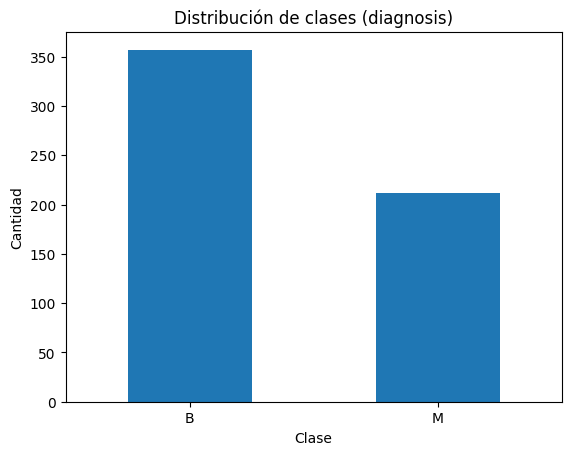

In [542]:
# Conteo de clases
print(df['diagnosis'].value_counts())

# Porcentaje de clases
print(df['diagnosis'].value_counts(normalize=True) * 100)

# Visualización
import matplotlib.pyplot as plt

df['diagnosis'].value_counts().plot(kind='bar', rot=0)
plt.title("Distribución de clases (diagnosis)")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()


**Resumen**:

**Conteo:** Hay 357 casos de diagnosis etiquetados como B y 212 casos etiquetados como M.

**Proporción:** La proporción de casos con enfermedad cardíaca (etiqueta b) es de 62.74%, mientras que la proporción de casos M es de 37.25%.

#Histogramas comparativos de variables clínicas según diagnóstico de HeartDisease

El análisis busca explorar la distribución de variables clínicas relevantes en la muestra de pacientes.
Para cada variable se muestra, primero, su histograma general considerando a toda la población.
Luego, se presentan las distribuciones diferenciadas según la presencia o ausencia de enfermedad cardíaca.
Esto permite identificar patrones y posibles diferencias asociadas al diagnóstico de HeartDisease.

In [543]:
from sklearn.feature_selection import SelectKBest, f_classif

X = df.drop(['diagnosis'], axis=1)
y = df['diagnosis'].map({'M':1, 'B':0})

selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X, y)

# Mostrar las mejores 5 variables
top_features = X.columns[selector.get_support()]
print(top_features)


Index(['perimeter_mean', 'concave points_mean', 'radius_worst',
       'perimeter_worst', 'concave points_worst'],
      dtype='object')


In [544]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


# Análisis de correlación de variables médicas Numéricas

 Muestra cómo se relacionan entre sí algunas variables importantes


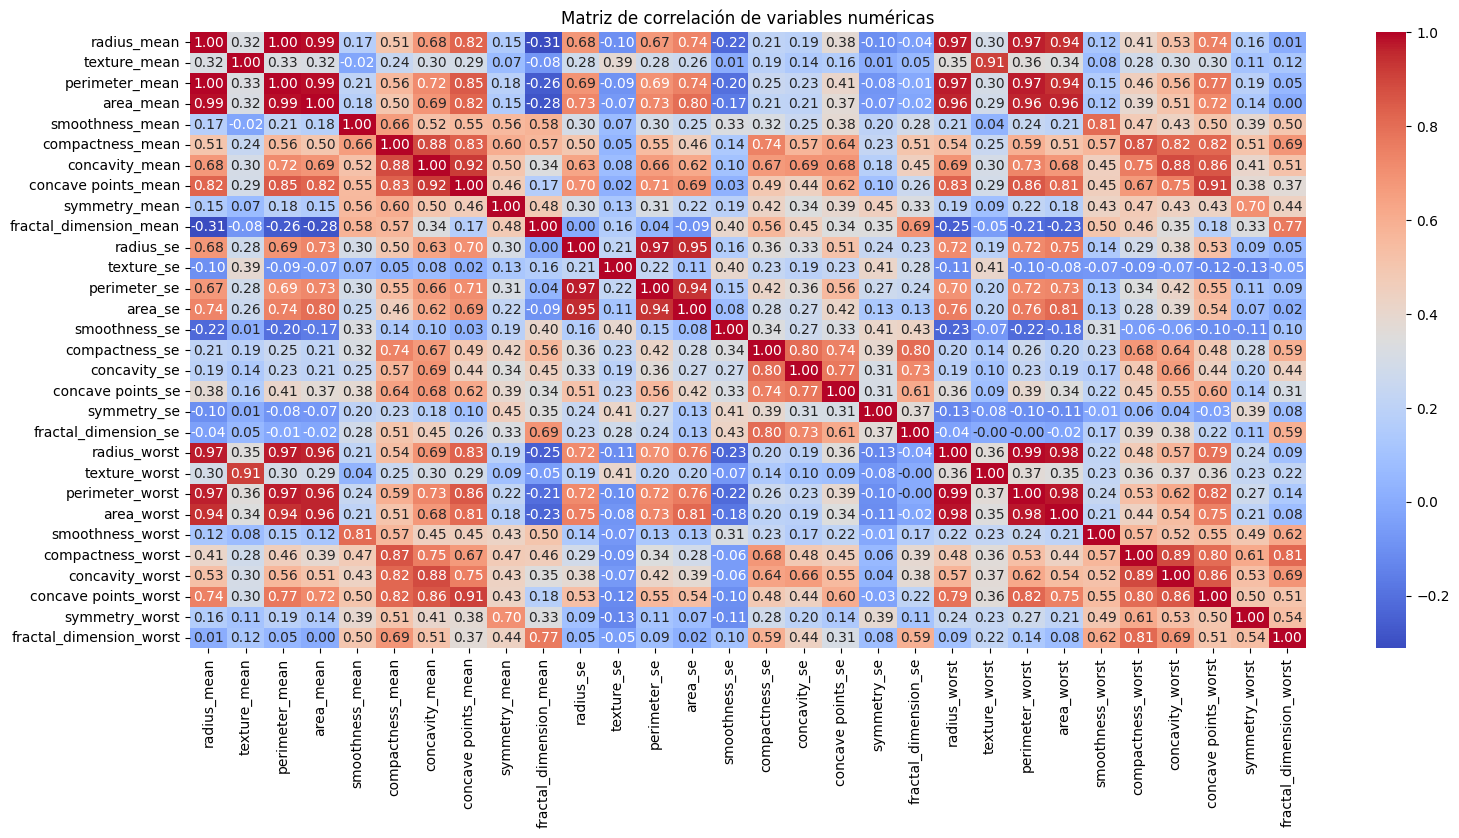

In [545]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#  Seleccionar solo columnas numéricas
df_num = df.select_dtypes(include=['int64', 'float64'])

# Calcular la matriz de correlación
corr_matrix = df_num.corr()
corr_matrix

# 3 Visualizar la matriz con un heatmap
plt.figure(figsize=(18,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación de variables numéricas")
plt.show()


In [546]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(10))


area_worst              0.139357
concave points_worst    0.132225
concave points_mean     0.107046
radius_worst            0.082848
perimeter_worst         0.080850
perimeter_mean          0.067990
concavity_mean          0.066917
area_mean               0.060462
concavity_worst         0.037339
radius_mean             0.034843
dtype: float64


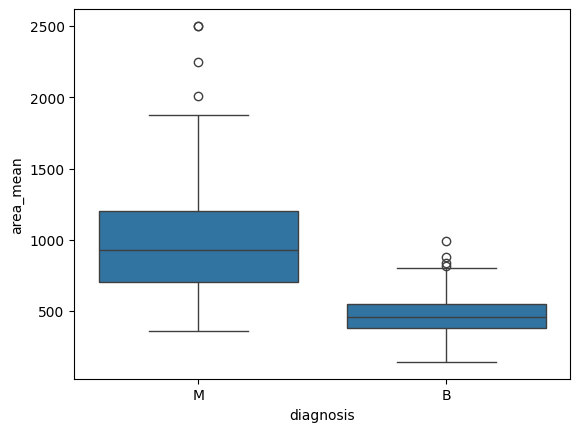

In [547]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='diagnosis', y='area_mean', data=df)
plt.show()


In [548]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(10))


area_worst              0.139357
concave points_worst    0.132225
concave points_mean     0.107046
radius_worst            0.082848
perimeter_worst         0.080850
perimeter_mean          0.067990
concavity_mean          0.066917
area_mean               0.060462
concavity_worst         0.037339
radius_mean             0.034843
dtype: float64


Elección de features


Se elige 5 features principales (como perimeter_worst, radius_worst y concave points_worst, area_worst, concave points_mean) por dos razones clave: poder predictivo y eficiencia del modelo.

Alto Poder Predictivo (Correlación):

Estas variables tienen la correlación más alta (cercana a 1) con la variable de diagnóstico (Maligno/Benigno).

Muestran una relación directa: un aumento en sus valores (mayor radio, perímetro o irregularidad) indica una probabilidad mucho mayor de que el tumor sea maligno.

Eficiencia y Claridad del Modelo:

Al seleccionarlas, eliminamos la redundancia (o multicolinealidad). Muchas de las 30 características originales se superponen (ej. radius_mean y area_mean). Al quedarnos con las 5 mejores, reducimos el ruido.

El sufijo _worst (peor valor) es crucial: estas mediciones representan los aspectos más extremos e irregulares del núcleo celular, que son los más importantes para el diagnóstico clínico de malignidad.

En resumen: Estas 5 features capturan la información esencial sobre el tamaño, la forma y la irregularidad del cáncer de mama de la manera más concisa y efectiva, lo que conduce a un modelo de Machine Learning más rápido, más preciso y fácil de interpretar.

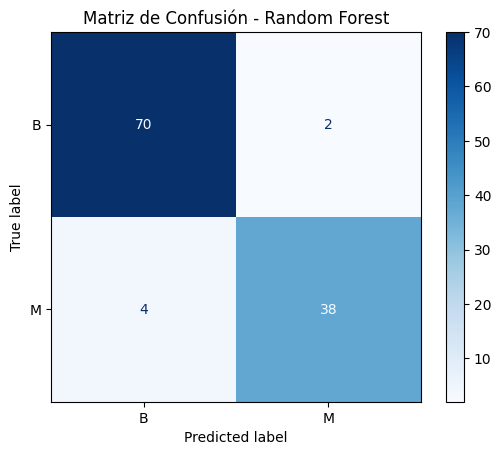

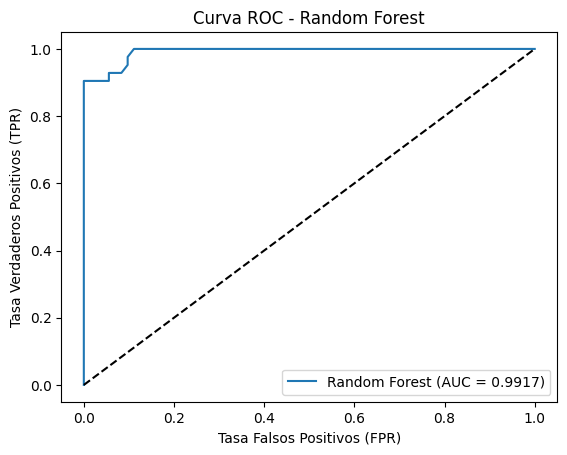


Reporte de Clasificación - Random Forest

              precision    recall  f1-score   support

 B (Benigno)       0.95      0.97      0.96        72
 M (Maligno)       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



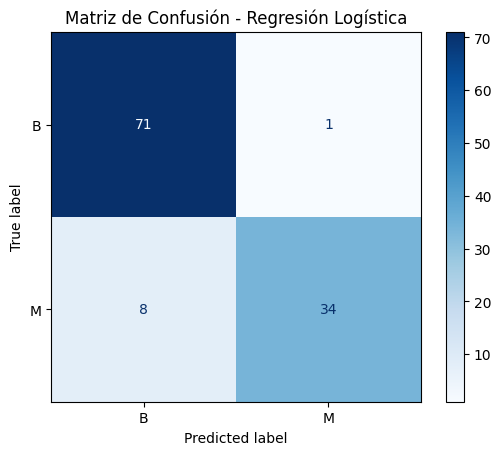

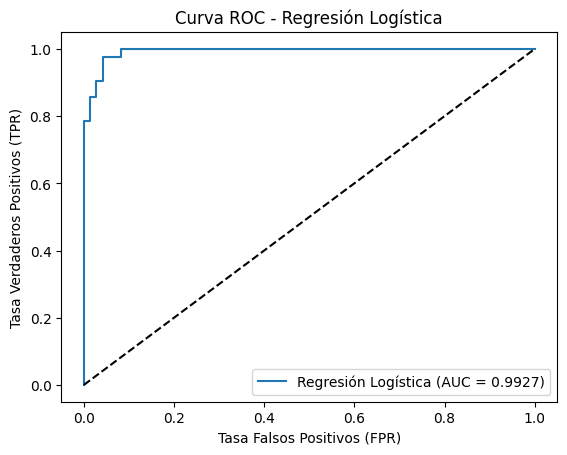


Reporte de Clasificación - Regresión Logística

              precision    recall  f1-score   support

 B (Benigno)       0.90      0.99      0.94        72
 M (Maligno)       0.97      0.81      0.88        42

    accuracy                           0.92       114
   macro avg       0.94      0.90      0.91       114
weighted avg       0.93      0.92      0.92       114



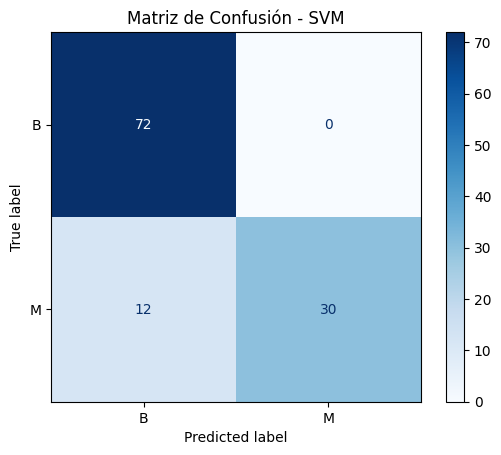

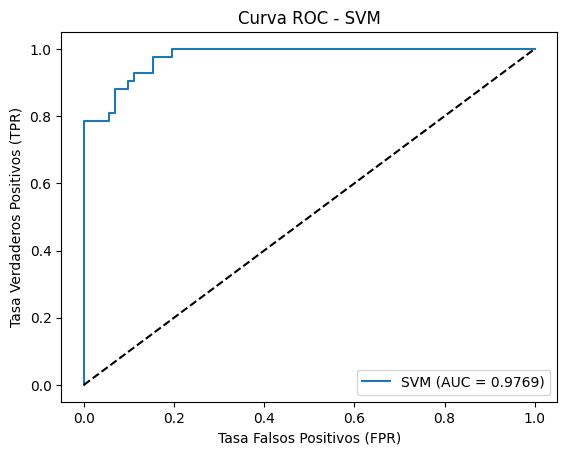


Reporte de Clasificación - SVM

              precision    recall  f1-score   support

 B (Benigno)       0.86      1.00      0.92        72
 M (Maligno)       1.00      0.71      0.83        42

    accuracy                           0.89       114
   macro avg       0.93      0.86      0.88       114
weighted avg       0.91      0.89      0.89       114


Resultados numéricos globales:

                     Accuracy  Recall  F1-Score     AUC  CV Accuracy (5-fold)
Random Forest          0.9474  0.9048    0.9268  0.9917                0.9403
Regresión Logística    0.9211  0.8095    0.8831  0.9927                0.9209
SVM                    0.8947  0.7143    0.8333  0.9769                0.9192


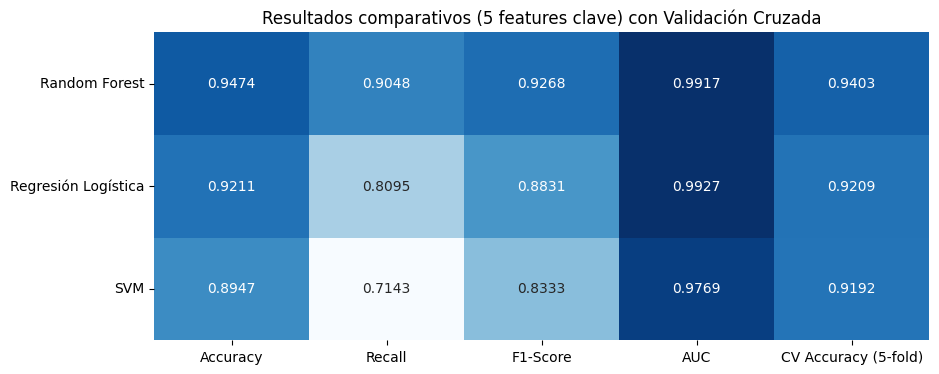

In [549]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, classification_report
)
import numpy as np

# --- Selección de 5 features clave ---
X = df[['radius_worst', 'perimeter_worst', 'area_worst',
        'concavity_worst', 'concave points_worst']]
y = df['diagnosis']

# --- Dividir en train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Modelos ---
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Regresión Logística": LogisticRegression(max_iter=5000, random_state=42),
    "SVM": SVC(random_state=42, probability=True)
}

results = {}
classification_reports = {}

# --- Entrenamiento, evaluación y validación cruzada ---
for name, model in models.items():
    # Entrenamiento
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Probabilidades para ROC/AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    # --- Guardar métricas numéricas ---
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred, pos_label='M'),
        'F1-Score': f1_score(y_test, y_pred, pos_label='M'),
        'AUC': auc(*roc_curve(y_test.map({'B': 0, 'M': 1}), y_proba)[:2]),
        # Validación cruzada Accuracy (5 folds)
        'CV Accuracy (5-fold)': np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy'))
    }

    # --- Matriz de Confusión ---
    cm = confusion_matrix(y_test, y_pred, labels=['B', 'M'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B', 'M'])
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()

    # --- Curva ROC ---
    fpr, tpr, _ = roc_curve(y_test.map({'B': 0, 'M': 1}), y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Tasa Falsos Positivos (FPR)')
    plt.ylabel('Tasa Verdaderos Positivos (TPR)')
    plt.title(f'Curva ROC - {name}')
    plt.legend(loc="lower right")
    plt.show()

    # --- Reporte de Clasificación ---
    report = classification_report(
        y_test, y_pred, target_names=['B (Benigno)', 'M (Maligno)'], output_dict=True
    )
    classification_reports[name] = report

    print(f"\nReporte de Clasificación - {name}\n")
    print(classification_report(y_test, y_pred, target_names=['B (Benigno)', 'M (Maligno)']))

# --- Resultados globales ---
results_df = pd.DataFrame(results).T
print("\nResultados numéricos globales:\n")
print(results_df.round(4))

# --- Tabla estilo heatmap ---
plt.figure(figsize=(10,4))
sns.heatmap(results_df.round(4), annot=True, cmap="Blues", cbar=False, fmt=".4f")
plt.title("Resultados comparativos (5 features clave) con Validación Cruzada")
plt.yticks(rotation=0)
plt.show()


#Modelo Random Forest Mejor Opción



El **Random Forest** es el **mejor modelo** porque consistentemente ofrece el **mejor balance entre rendimiento y robustez** en las métricas clave, siendo especialmente superior en la clasificación de la clase crítica, **M (Maligno)**.

Lidera en el F1-Score general y demuestra la mayor estabilidad, como lo confirma la Validación Cruzada.

---

### 1. Robustez y Rendimiento General

La robustez se evalúa al comparar el rendimiento en el *Test Set* (datos de prueba únicos) y el promedio obtenido a través de la *Validación Cruzada (CV)*.

| Métrica | Random Forest | Regresión Logística | SVM | Conclusión |
| :--- | :--- | :--- | :--- | :--- |
| **Accuracy (Test)** | **0.9474** | 0.9211 | 0.8947 | **Líder**. Mayor porcentaje de predicciones correctas. |
| **F1-Score (Test)** | **0.9268** | 0.8831 | 0.8333 | **Líder**. El mejor indicador para evaluar el rendimiento equilibrado entre precisión y recall. |
| **CV Accuracy (5-fold)** | **0.9403** | 0.9209 | 0.9192 | **Líder**. Muestra que el modelo es **más estable** y generaliza mejor a datos no vistos. |
| **AUC** | 0.9917 | **0.9927** | 0.9769 | Todos son excelentes separadores de clases, con la Regresión Logística ligeramente por encima. |

---

### 2. Capacidad para Detectar Casos Críticos (Clase Maligno - M)

En problemas de diagnóstico, es vital maximizar el **Recall** de la clase positiva (**Maligno**), para así minimizar los **Falsos Negativos** (no detectar un caso maligno), que es el error más costoso.

| Métrica (Clase M) | Random Forest | Regresión Logística | SVM | Importancia |
| :--- | :--- | :--- | :--- | :--- |
| **Recall (Maligno)** | **0.90** | 0.81 | 0.71 | **Métrica Clave**: Minimiza los Falsos Negativos (deja de lado solo al 10% de los casos M). **Random Forest es el mejor.** |
| **Precision (Maligno)** | 0.95 | 0.97 | **1.00** | Mide cuántas de las predicciones de 'Maligno' fueron correctas. SVM es perfecto, pero a costa de un Recall muy bajo. |
| **F1-Score (Maligno)** | **0.93** | 0.88 | 0.83 | El mejor indicador de equilibrio para la clase Maligno. **Random Forest es el mejor.** |

---

### 3. Conclusión Final

El **Random Forest** es la elección óptima por dos motivos principales:

1.  **Alto F1-Score (0.9268):** Indica que ha logrado el balance ideal, funcionando excepcionalmente bien en ambas clases.
2.  **Recall Superior en la Clase Maligno (0.90):** Demuestra la mayor capacidad para identificar correctamente los casos más críticos, haciendo que sea el modelo más seguro y útil para una aplicación médica.

In [550]:
import json


model = models["Random Forest"]  # Tomamos el RandomForest del diccionario

# Paths
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

# Guardar modelo
model_path = ARTIFACTS_DIR / "model.pkl"
joblib.dump(model, model_path)
print("Artefacto guardado en:", model_path.resolve())

manifest = {
    "name": "breast_cancer_random_forest_model",
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "framework": "scikit-learn",
    "sklearn_version": sklearn.__version__,
    "python_version": platform.python_version(),
    "features": list(X.columns),
    "target": "diagnosis",
    "model_type": type(rf_model).__name__,
    "model_params": rf_model.get_params(),
    "dataset": {
        "num_samples": len(df),
        "num_features": X.shape[1],
        "class_distribution": y.value_counts().to_dict()
    },
    "metrics": {
        "test_accuracy": float(results["Random Forest"]["Accuracy"]),
        "recall": float(results["Random Forest"]["Recall"]),
        "f1_score": float(results["Random Forest"]["F1-Score"]),
        "roc_auc": float(results["Random Forest"]["AUC"]),
        "cv_accuracy_5fold": float(results["Random Forest"]["CV Accuracy (5-fold)"])
    },
    "artifact_path": str(model_path.resolve()),
    "dependencies": {
        "python": platform.python_version(),
        "scikit-learn": sklearn.__version__,
        "joblib": joblib.__version__,
        "numpy": np.__version__,
        "pandas": pd.__version__
    }
}


# Guardar manifest
manifest_path = ARTIFACTS_DIR / "model_card.json"
with open(manifest_path, "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2, ensure_ascii=False)

print("Manifest guardado en:", manifest_path.resolve())


Artefacto guardado en: /content/artifacts/model.pkl
Manifest guardado en: /content/artifacts/model_card.json
